In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.nn import Module
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Customized CNN model
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv2 = nn.Conv2d(64, 64, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv3 = nn.Conv2d(64, 128, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv4 = nn.Conv2d(128, 128, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv5 = nn.Conv2d(128, 256, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv6 = nn.Conv2d(256, 256, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv7 = nn.Conv2d(256, 256, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv8 = nn.Conv2d(256, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv9 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv10 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv11 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv12 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv13 = nn.Conv2d(512, 512, kernel_size = (3, 3), stride = (1, 1), padding = (1, 1))
        self.fc1 = nn.Linear(4 * 4 * 512, 256)
        self.fc2 = nn.Linear(256, 1)
        
        
    # Defining the forward pass    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [16]:
# prepare the training data
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

In [8]:
input_path = '/home/chenyu/Desktop/CNNmeasurement/TrainingData_CoarseCNN/'
train_data = np.load(input_path + 'FullRandom_40mrad_highCs_3fold_C5negC1_C3negC1_whiteNoise_32pxGaussian_multiNoise_30pA_128pxRonch_x25000.npy')
print(train_data.shape)

train_label = np.load(input_path + 'FullRandom_40mrad_highCs_3fold_C5negC1_C3negC1_whiteNoise_32pxGaussian_multiNoise_30pA_newEmit_x25000.npy')
train_label_1 = (train_label - np.amin(train_label))/(np.amax(train_label) - np.amin(train_label))
print(train_label.shape)

train_label = np.load(input_path + 'FullRandom_40mrad_highCs_3fold_C5negC1_C3negC1_whiteNoise_32pxGaussian_multiNoise_30pA_defocus_x25000.npy')
train_label_2 = (train_label - np.amin(train_label))/(np.amax(train_label) - np.amin(train_label))
print(train_label.shape)

train_label = (train_label_1 + train_label_2) / 2

(25002, 128, 128)
(25002,)
(25002,)


In [9]:
def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input    

In [10]:
class CatsAndDogsDataset(Dataset):
    def __init__(self, data, labels, transform = None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        img = scale_range(self.data[index,:,:].astype('float'), 0, 1)
        new_channel = np.zeros(img.shape)
        img = np.dstack((img, new_channel, new_channel))
        img = Image.fromarray(np.uint8(img*255))
        y_label = torch.tensor(float(self.labels[index]))

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [35]:
transform = transforms.Compose(
        [
            transforms.Resize((140, 140)),
            transforms.RandomCrop((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize((1.0, 1.0, 1.0), (1.0, 1.0, 1.0)),
        ]
    )

In [36]:
# training hyperparameters
num_epochs = 10
learning_rate = 0.00001
train_CNN = False
batch_size = 32
shuffle = True
pin_memory = True
num_workers = 1

In [37]:
dataset = CatsAndDogsDataset(train_data, train_label, transform = transform)

train_set, validation_set = torch.utils.data.random_split(dataset,[20000,5002])

train_loader = DataLoader(dataset=train_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers,pin_memory=pin_memory)

validation_loader = DataLoader(dataset=validation_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)

In [38]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


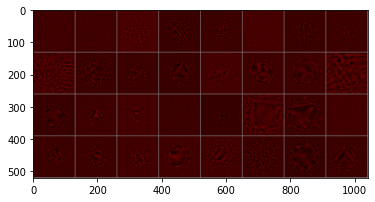

In [39]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
imshow(torchvision.utils.make_grid(images))

In [18]:
# Call the CNN model and start training
model = Net().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
def check_accuracy(loader, model):
    if loader == train_loader:
        print("Checking accuracy on training data")
    else:
        print("Checking accuracy on validation data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            predictions = torch.tensor([1.0 if i >= 0.5 else 0.0 for i in scores]).to(device)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
    return f"{float(num_correct)/float(num_samples)*100:.2f}"
#         print(
#             f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
#         )
#     model.train()

In [20]:
def train():
    model.train()
    for epoch in range(num_epochs):
        loop = tqdm(train_loader, total = len(train_loader), leave = True)
        if epoch % 2 == 0:
            loop.set_postfix(val_acc = check_accuracy(validation_loader, model))
        for imgs, labels in loop:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
            loop.set_postfix(loss = loss.item())

if __name__ == "__main__":
    train()

  0%|                                                   | 0/625 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|                                     | 0/625 [00:16<?, ?it/s, val_acc=0.00][W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
/home/chenyu/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to bro

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
  0%|                                                   | 0/625 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
  0%|                                                   | 0/625 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
  0%|                                                   | 0/625 [00:00<?, ?it/s]

Checking accuracy on validation data


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch [9/10]: 100%|██████████████| 625/625 [02:13<00:00,  4.68it/s, loss=0.0263]
